In [25]:
import sys
sys.path.append('../')

import albumentations as A
import src.training as train
import src.dataset as dataset
from  src.models import resnet,siamesenet
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms

## Traning dataset and loaders creation

In [79]:
batch_size = 128

transform = transforms.Compose([
    transforms.Resize((105, 105)),
    transforms.ToTensor()
    ])

albumentations_transform = A.Compose([
    A.ColorJitter(brightness=0.0, contrast=0.0, saturation=0.0, hue=0.25, p=0.0),
    A.GridElasticDeform(num_grid_xy = (7,7), magnitude = 30),
    A.Resize(105,105),
])
same_class_transform = dataset.TorchAlbumentationTransform(albumentations_transform)

train_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/train",
    transform = transform,
    max_positive_combinations=10,
    max_negative_combinations=10,
    same_class_negatives=0.5,
    same_class_transform=same_class_transform
    )

validation_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/val",
    transform = transform,
    max_positive_combinations=5,
    max_negative_combinations=5,
    same_class_negatives=0.5,
    same_class_transform=same_class_transform
    )

dataloader = {
    'train': DataLoader(train_dataset, shuffle=True, batch_size=batch_size),
    'val': DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
}

In [43]:
img1,img2,label = next(iter(dataloader['train']))

Class: 1.0


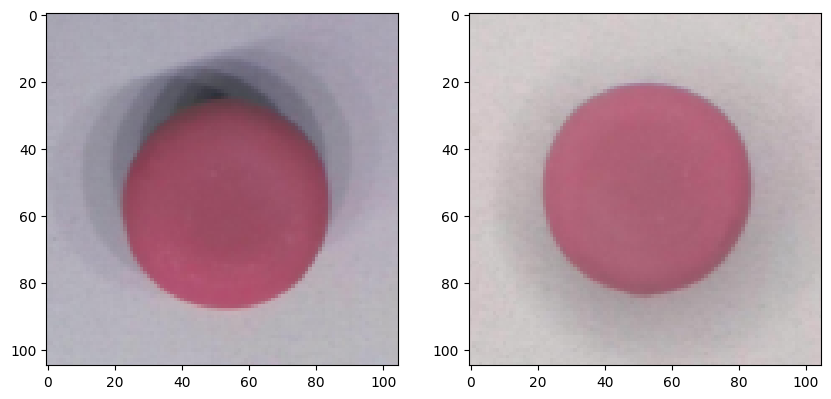

In [44]:
index = 15
print("Class:",label[15].item())
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(img1[index].permute(1, 2, 0))
ax[1].imshow(img2[index].permute(1, 2, 0))

### Create test dataset

In [80]:
test_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/test",
    transform = transform,
    max_positive_combinations=5,
    max_negative_combinations=5,
    )
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

## Resnet model

In [69]:
backbone = resnet.prunnedResnet18()
model = siamesenet.siameseNet(backbone,512)
checkpoint = torch.load('../checkpoints/Siamese-restnet.ckpt')
model.load_state_dict(checkpoint['model_state_dict'])

Layer (type:depth-idx)                        Param #
Siamese                                       --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,6

<All keys matched successfully>

Predicted class is 1.0


{'Label': 1.0, 'Probability': 0.8561659455299377}

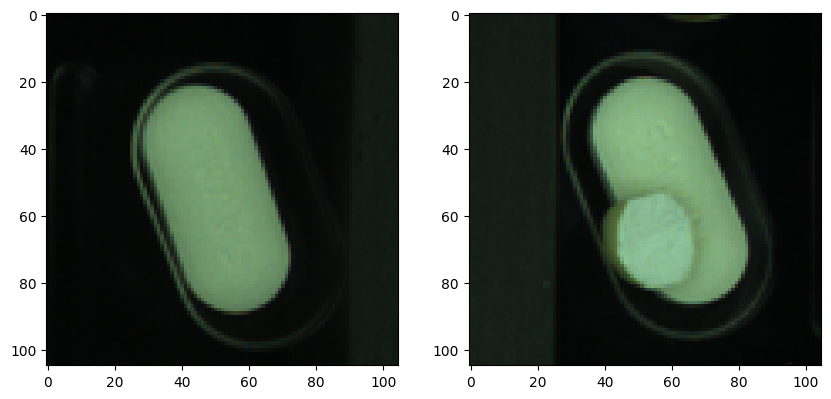

In [71]:
train.test_sample(model,
            '..//data//rl_scenario_test/pill_2.png', 
            '..//data//rl_scenario_test/pill_10.png',
            input_size=(105,105))

Test Accuracy: 0.9618
Test Precision: 0.8869
Test Recall: 0.9423


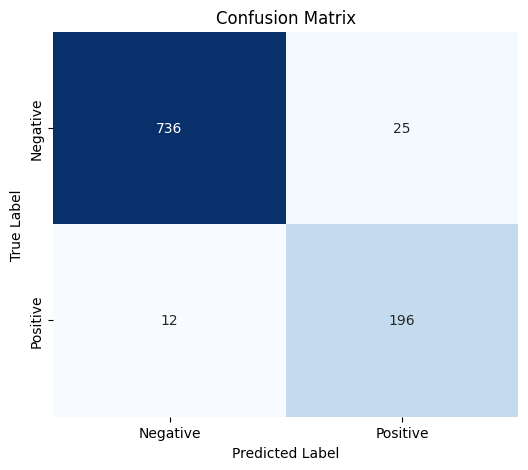

In [56]:
res = train.evaluate_model(test_dataloader,model)

## Resnet model with weighted loss

In [51]:
backbone = resnet.prunnedResnet18()
model = siamesenet.siameseNet(backbone,512)
checkpoint = torch.load('../checkpoints/Siamese-restnet-weighted_loss.ckpt')
model.load_state_dict(checkpoint['model_state_dict'])

Layer (type:depth-idx)                        Param #
Siamese                                       --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,6

<All keys matched successfully>

Predicted class is 1.0


{'Label': 1.0, 'Probability': 0.5452215671539307}

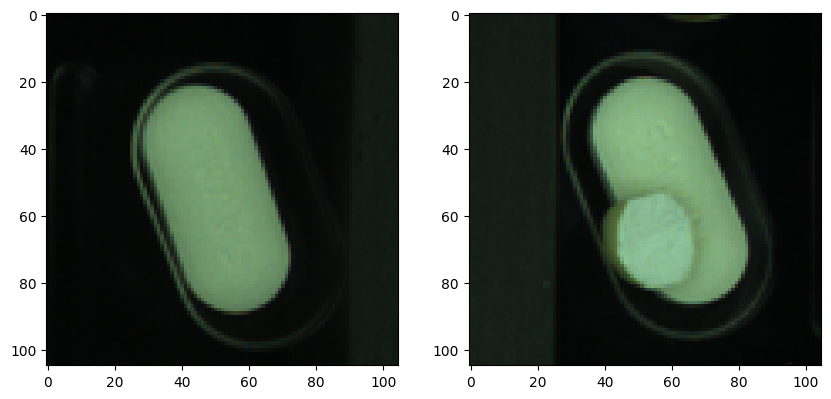

In [67]:
train.test_sample(model,
            '..//data//rl_scenario_test/pill_2.png', 
            '..//data//rl_scenario_test/pill_10.png',
            input_size=(105,105))

Test Accuracy: 0.9505
Test Precision: 0.8960
Test Recall: 0.8702


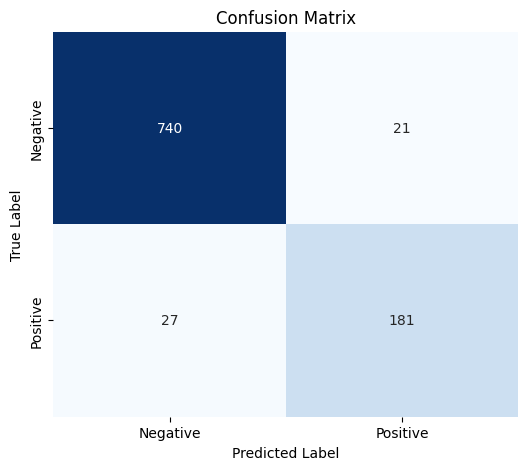

In [53]:
res = train.evaluate_model(test_dataloader,model)

## Original paper model


In [81]:
backbone = siamesenet.OneShot()
model = siamesenet.siameseNet(backbone,backbone_output_size=9216)
checkpoint = torch.load('../checkpoints/Siamese.ckpt')
model.load_state_dict(checkpoint['model_state_dict'])

Layer (type:depth-idx)                   Param #
Siamese                                  --
├─OneShot: 1-1                           --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  19,264
│    │    └─ReLU: 3-2                    --
│    │    └─BatchNorm2d: 3-3             128
│    │    └─MaxPool2d: 3-4               --
│    │    └─Conv2d: 3-5                  401,536
│    │    └─ReLU: 3-6                    --
│    │    └─BatchNorm2d: 3-7             256
│    │    └─MaxPool2d: 3-8               --
│    │    └─Conv2d: 3-9                  262,272
│    │    └─ReLU: 3-10                   --
│    │    └─BatchNorm2d: 3-11            256
│    │    └─MaxPool2d: 3-12              --
│    │    └─Conv2d: 3-13                 524,544
│    │    └─ReLU: 3-14                   --
├─Sequential: 1-2                        --
│    └─Linear: 2-2                       37,752,832
│    └─Sigmoid: 2-3                      --
├─Linear: 1-3                            

<All keys matched successfully>

Predicted class is 1.0


{'Label': 1.0, 'Probability': 0.5452215671539307}

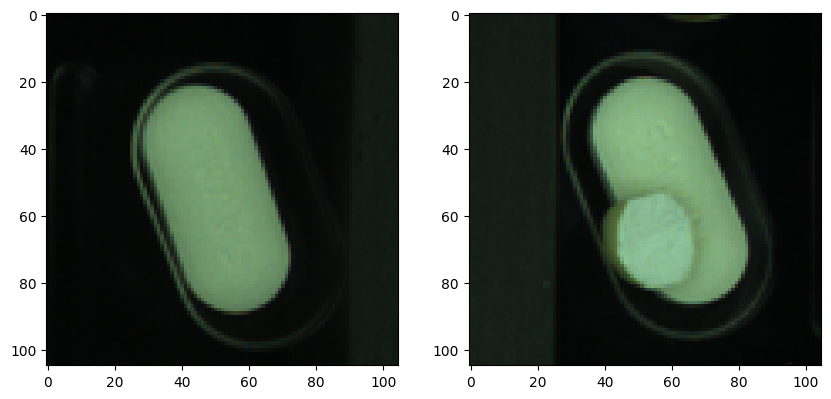

In [82]:
train.test_sample(model,
            '..//data//rl_scenario_test/pill_2.png', 
            '..//data//rl_scenario_test/pill_10.png',
            input_size=(105,105))

Test Accuracy: 0.9711
Test Precision: 0.9128
Test Recall: 0.9567


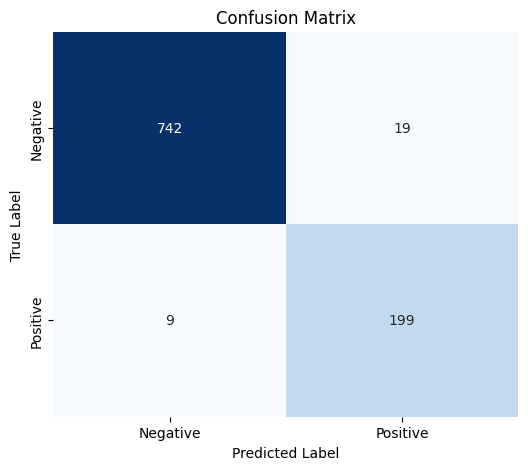

In [83]:
res = train.evaluate_model(test_dataloader,model)

## Resnet model with augumented negatives
This was trained with 260x260 images, so I need to create the loaders again.

In [59]:
transform = transforms.Compose([
    transforms.Resize((260, 260)),
    transforms.ToTensor()
    ])

albumentations_transform = A.Compose([
    A.ColorJitter(brightness=0.0, contrast=0.0, saturation=0.0, hue=0.25, p=0.0),
    A.GridElasticDeform(num_grid_xy = (7,7), magnitude = 30),
    A.Resize(260,260),
])
same_class_transform = dataset.TorchAlbumentationTransform(albumentations_transform)

train_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/train",
    transform = transform,
    max_positive_combinations=10,
    max_negative_combinations=10,
    same_class_negatives=0.5,
    same_class_transform=same_class_transform
    )

validation_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/val",
    transform = transform,
    max_positive_combinations=5,
    max_negative_combinations=5,
    same_class_negatives=0.5,
    same_class_transform=same_class_transform
    )

dataloader = {
    'train': DataLoader(train_dataset, shuffle=True, batch_size=batch_size),
    'val': DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
}

test_dataset = dataset.SiameseDataset(
    "../data/cropped_selected_split_data/test",
    transform = transform,
    max_positive_combinations=5,
    max_negative_combinations=5,
    )
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [60]:
backbone = resnet.prunnedResnet18()
model = siamesenet.siameseNet(backbone,512)
checkpoint = torch.load('../checkpoints/Siamese-resnet-augmentedNegatives.ckpt')
model.load_state_dict(checkpoint['model_state_dict'])

Layer (type:depth-idx)                        Param #
Siamese                                       --
├─ResNet: 1-1                                 --
│    └─Conv2d: 2-1                            (9,408)
│    └─BatchNorm2d: 2-2                       (128)
│    └─ReLU: 2-3                              --
│    └─MaxPool2d: 2-4                         --
│    └─Sequential: 2-5                        --
│    │    └─BasicBlock: 3-1                   (73,984)
│    │    └─BasicBlock: 3-2                   (73,984)
│    └─Sequential: 2-6                        --
│    │    └─BasicBlock: 3-3                   (230,144)
│    │    └─BasicBlock: 3-4                   (295,424)
│    └─Sequential: 2-7                        --
│    │    └─BasicBlock: 3-5                   (919,040)
│    │    └─BasicBlock: 3-6                   (1,180,672)
│    └─Sequential: 2-8                        --
│    │    └─BasicBlock: 3-7                   (3,673,088)
│    │    └─BasicBlock: 3-8                   (4,720,6

<All keys matched successfully>

Predicted class is 1.0


{'Label': 1.0, 'Probability': 0.8371401429176331}

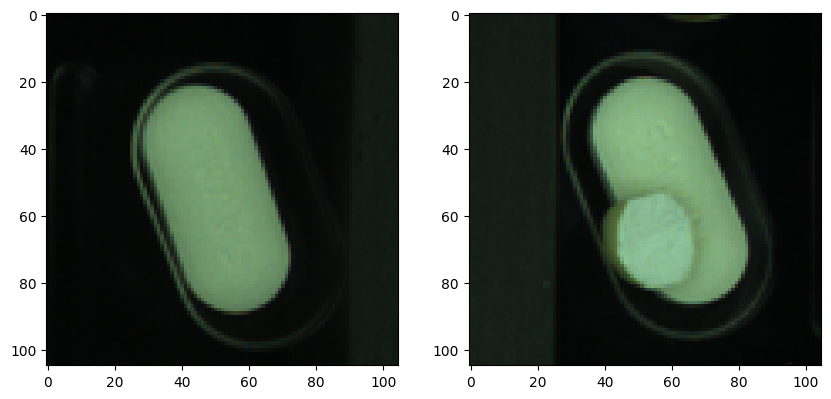

In [61]:
train.test_sample(model,
            '..//data//rl_scenario_test/pill_2.png', 
            '..//data//rl_scenario_test/pill_10.png',
            input_size=(260,260))

Predicted class is 0.0


{'Label': 0.0, 'Probability': 0.01995910331606865}

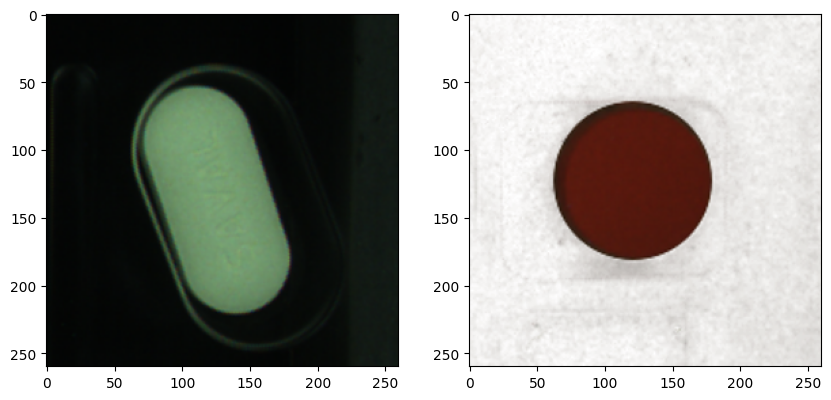

In [64]:
train.test_sample(model,
            '..//data//rl_scenario_test/pill_2.png', 
            '..//data//rl_scenario_test/pill_15.png',
            input_size=(260,260))

Test Accuracy: 0.9474
Test Precision: 0.8905
Test Recall: 0.8606


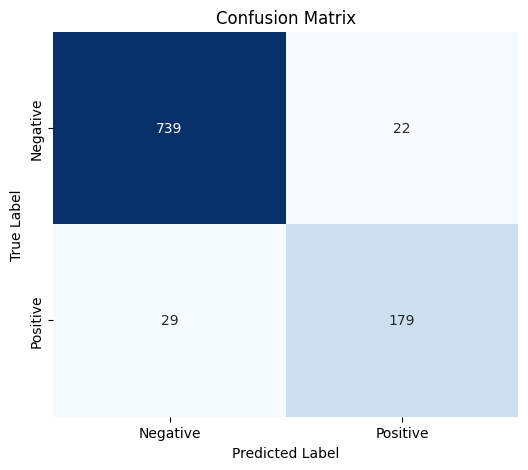

In [65]:
res = train.evaluate_model(test_dataloader,model)